# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.

Most illustrative plots of how the pandemic is being controlled:
- [Relative increases per day by country](#country_relative_increases)
- [Relative increases per day by state](#us_state_relative_increases)

Visualizations found in this notebook:
- [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
- [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
- [Time-series plots of infections in most infected countries](#time-series_countries)
- [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
- [Relative increases per day by country](#country_relative_increases)
- [Time-series plots of mortality](#time-series_country_mortality)
- [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
  - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
- [Density of infections per million people](#density_of_infections_by_country)
- [How many days behind is each country from Italy?](#days_behind)
- [US states with the most new infections](#states_most_infections)
- [Time-series plots of infections in most-infected states](#time-series_states)
- [State forecasts of infections/deaths 1 and 7 days in the future](#forecast_us_state)
- [States and their daily increase fraction in confirmed cases/deaths](#us_state_daily_increase_fraction)
- [Compare US state infections against Washington](#state_infections_vs_wa)
- [Compare US state infections against New York](#state_infections_vs_ny)
- [Mortality rate by US state](#mortality_by_us_state)
- [Relative increases per day by state](#us_state_relative_increases)

In [1]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [181]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = 12,6
#plt.style.use('seaborn-dark-palette')
plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [182]:
# define paths to each raw file
d_ts = {}
#d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
#d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [183]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [184]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')
        
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

metric: confirmed at 2020-04-10 21:57:04.322274
metric: deaths at 2020-04-10 21:57:05.383423
Latest data from 2020-04-10


In [185]:
# # TEMP FIX - There are data issues on 2020-03-18; these are corrections that will hopefully be fixed
# state_fixes_20200318 = {'New York': 3083, 
#                         'Washington': 1187, 
#                         'California': 870, 
#                         'Florida': 330, 
#                         'New Jersey': 427, 
#                         'Louisiana': 280}
# for state, val in state_fixes_20200318.items():
#     dfp.loc[(dfp.country == 'US') & 
#             (dfp['date'] == datetime.datetime(2020,3,18)) & 
#             (dfp.state == state), 'confirmed'] = val

In [186]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   #'recovered': np.sum,
               }))
#dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [187]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    #'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='deaths', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

,date,country,confirmed,confirmed_new,deaths,deaths_new,mortality_rate
0,2020-04-10,Italy,147577,3951,18849,570,0.127723
1,2020-04-10,US,496535,35098,18586,2108,0.037431
2,2020-04-10,Spain,158273,5051,16081,634,0.101603
3,2020-04-10,France,125931,7150,13215,987,0.104938
4,2020-04-10,United Kingdom,74605,8733,8974,981,0.120287
5,2020-04-10,Iran,68192,1972,4232,122,0.062060
6,2020-04-10,China,82941,58,3340,1,0.040270
7,2020-04-10,Belgium,26667,1684,3019,496,0.113211
8,2020-04-10,Germany,122171,3990,2767,160,0.022649
9,2020-04-10,Netherlands,23249,1346,2520,117,0.108392


<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [188]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).head(10)

,date,country,confirmed,confirmed_new,deaths,deaths_new,mortality_rate
1,2020-04-10,US,496535,35098,18586,2108,0.037431
4,2020-04-10,United Kingdom,74605,8733,8974,981,0.120287
3,2020-04-10,France,125931,7150,13215,987,0.104938
2,2020-04-10,Spain,158273,5051,16081,634,0.101603
11,2020-04-10,Turkey,47029,4747,1006,98,0.021391
8,2020-04-10,Germany,122171,3990,2767,160,0.022649
0,2020-04-10,Italy,147577,3951,18849,570,0.127723
18,2020-04-10,Ecuador,7161,2196,297,25,0.041475
5,2020-04-10,Iran,68192,1972,4232,122,0.062060
36,2020-04-10,Russia,11917,1786,94,18,0.007888


<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

In [189]:
def plot_countries(
    dfp_country,
    countries=dfp_top_countries.iloc[:10]['country'],
    plot_cols=['confirmed', 'deaths', 'recovered', 'active', 'confirmed_new'],
    country_col='country',
    n_columns=2,
    y_min=1,
    y_max=dfp_top_countries['confirmed'].max() * 1.5,
    date_col='date',
    y_label='num_cases',
    date_min=datetime.datetime(2020,2,1),
    is_log=True,
):
    i = 1
    n_rows = int(np.ceil(len(countries) / n_columns))
    plt.figure(figsize=(12,n_rows*5))
    
    for country in countries:
        dfp_plot = dfp_country[(dfp_country[country_col] == country) &
                               (dfp_country[date_col] >= date_min)
                              ]
        dfp_plot = dfp_plot[dfp_plot['confirmed_new'] != 0]
        plt.subplot(n_rows, n_columns, i)
        for key in plot_cols:
            plt.plot(dfp_plot[date_col], dfp_plot[key], alpha=0.7, label=key)
        plt.legend(loc='best')
        plt.ylabel(f'{y_label}')
        plt.title(f'{country_col}: {country}')
        if is_log:
            plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()

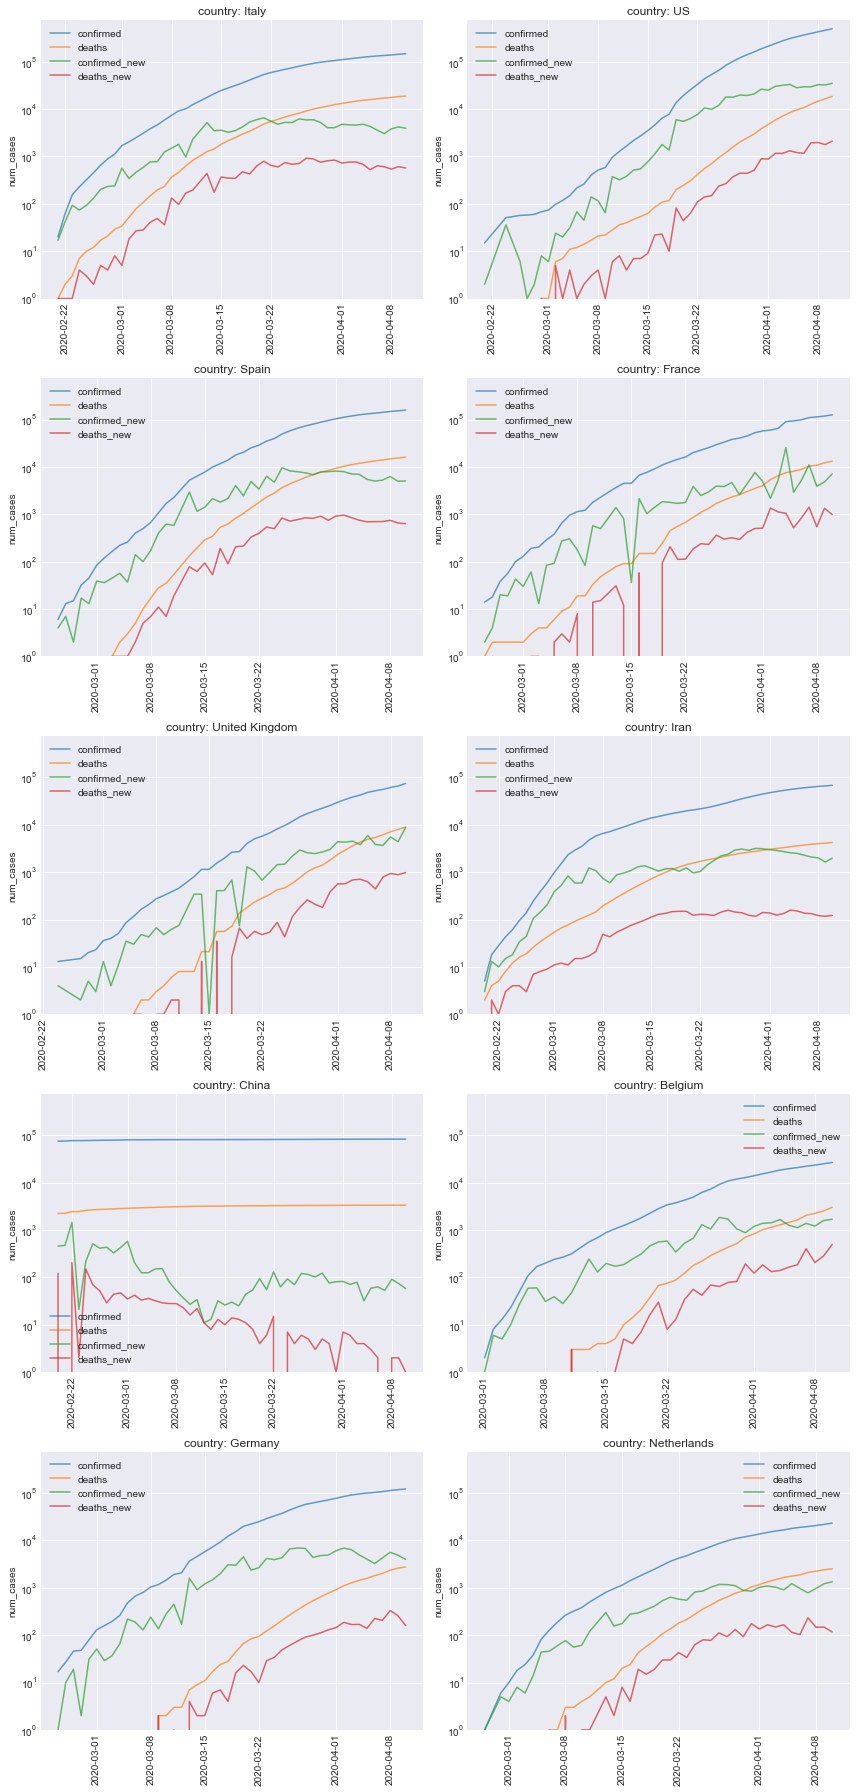

In [190]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

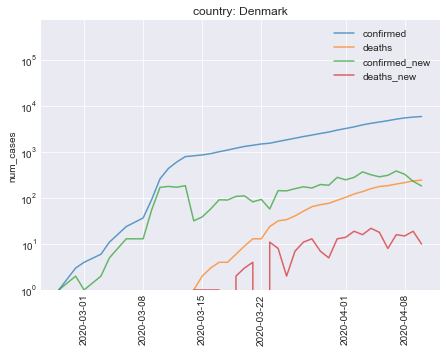

In [235]:
plot_countries(dfp_country, 
               countries=['Denmark'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

In [193]:
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, days=1):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    for col in ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=None,
              col_locale='country'
             ):
    warnings.simplefilter('ignore', np.RankWarning)
    if date_most_recent is None:
        date_most_recent = dfp_country_recent['date'].max()
    dfp_country_recent = dfp_country_recent.set_index(col_locale)
    
    # fit
    dfp_country_recent_clean = dfp_country_recent[(dfp_country_recent['date'] <= date_most_recent) &
                                                  (dfp_country_recent[col_fit] > 0)
                                                 ]
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby([col_locale]).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'intercept']).reset_index() #'slope', 
    fit_col = col_fit.split('_')[0]
    dfp_country_recent[f"frac_increase_{fit_col}"] = (10**(dfp_country_recent['slope'] * 86400) - 1)
    #dfp_country_recent = dfp_country_recent.rename(columns={'slope': f'slope_{col_fit.split("_")[0]}'})
    return dfp_country_recent, dfp_country_confirmed_fit

def fit_exp(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False
           ):
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    
    # make predictions to past, then future
    # add in future points
    dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    #dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
    #dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0, sort=False)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                           col_fit='deaths_log', 
                                                           col_pred='deaths_pred', 
                                                           col_locale=col_locale, 
                                                           date_most_recent=date_most_recent
                                                          )
    dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, 
                                                              col_fit='confirmed_log', 
                                                              col_pred='confirmed_pred', 
                                                              col_locale=col_locale, 
                                                              date_most_recent=date_most_recent
                                                             )
    dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    dfp_forecasts_out = dfp_forecasts[['date', 
                                       col_locale, 
                                       'confirmed_pred', 
                                       'deaths_pred', 
                                       'mortality_rate_pred', 
                                       'frac_increase_confirmed', 
                                       'frac_increase_deaths'
                                      ]].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({'frac_increase_confirmed': np.mean, 
                              'frac_increase_deaths': np.mean}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=['confirmed_pred', 'deaths_pred', 'mortality_rate_pred']
                                                 ).sort_values(by=('deaths_pred', dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                  ):
    # subset the top countries
    dfp_non_pred = dfp_country_recent.dropna(subset=['deaths'])
    dt_max = dfp_non_pred['date'].max()
    dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                         sort_values(by='deaths', ascending=0).
                         iloc[:n_countries]
                        )
    top_countries = (dfp_top_countries.
                     iloc[:n_countries][col_locale].values
                    )

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    y_max = dfp_country_recent['confirmed_pred'].max()
    y_min = max(dfp_country_recent['deaths'].min(), 1)

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in ['confirmed', 'deaths']:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast(dfp_forecasts_out, dfp_country_recent, n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

##### Forecasts based on last 1 week

confirmed_pred                       deaths_pred             \
date               2020-04-11 2020-04-17 2020-05-01  2020-04-11 2020-04-17   
country                                                                      
US                   540909.0   868471.0  2621568.0     21548.0    48295.0   
Italy                151703.0   179038.0   263529.0     19570.0    24046.0   
Spain                165207.0   207548.0   353450.0     17055.0    23001.0   
France               134065.0   188632.0   418454.0     14684.0    26155.0   
United Kingdom        80243.0   136134.0   467309.0     10163.0    21207.0   
Iran                  70961.0    86562.0   137628.0      4401.0     5384.0   
Belgium               28241.0    40666.0    95216.0      3441.0     8102.0   
China                 83009.0    83418.0    84381.0      3341.0     3351.0   
Germany              127564.0   162989.0   288732.0      3208.0     6380.0   
Netherlands           24402.0    33467.0    69941.0      2764.0     4294.0   

                          mortality_rate_pred                        \
date           2020-05-01          2020-04-11 2020-04-17 2020-05-01   
country                                                               
US               317479.0            0.039837   0.055609   0.121103   
Italy             38885.0            0.129002   0.134307   0.147555   
Spain             46218.0            0.103234   0.110823   0.130762   
France           100589.0            0.109529   0.138656   0.240382   
United Kingdom   117984.0            0.126653   0.155780   0.252475   
Iran               8615.0            0.062020   0.062198   0.062596   
Belgium           59743.0            0.121844   0.199233   0.627447   
China              3373.0            0.040249   0.040171   0.039973   
Germany           31730.0            0.025148   0.039144   0.109894   
Netherlands       11999.0            0.113269   0.128305   0.171559   

               frac_increase_confirmed frac_increase_deaths  
date                                                         
country                                                      
US                            0.082111             0.143970  
Italy                         0.027996             0.034926  
Spain                         0.038759             0.051108  
France                        0.058563             0.100993  
United Kingdom                0.092093             0.130418  
Iran                          0.033675             0.034149  
Belgium                       0.062652             0.153390  
China                         0.000820             0.000471  
Germany                       0.041690             0.121401  
Netherlands                   0.054060             0.076153

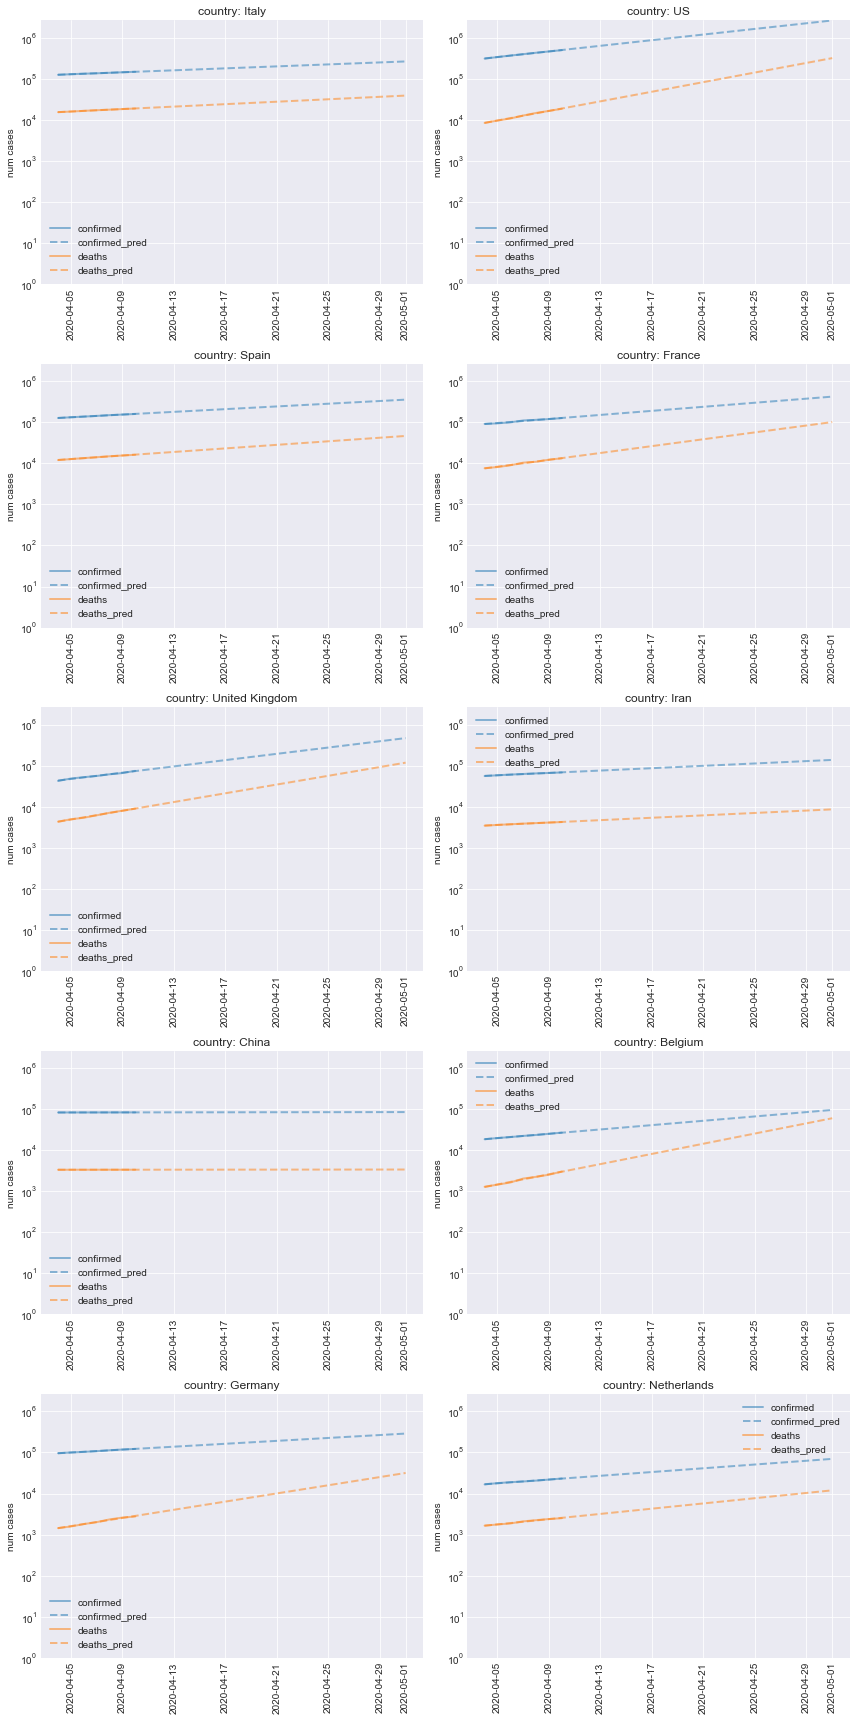

In [194]:
dfp_country_recent_1, dfp_forecasts_out_1 = fit_exp(dfp_country, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21], 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_1)

In [195]:
save_forecast(dfp_forecasts_out_1, dfp_country_recent_1, 7)

saved forecast to predictions/covid-19_country_forecast_from_2020-04-10_n_days_training=7.csv


<a id='country_relative_increases'></a>
### Relative increases per day by country

In [196]:
def find_relative_increase_data_and_plot(dfp_us_g, 
                                         n_days_fit=7, 
                                         dt=datetime.datetime(2020,3,10),
                                         n_locales=7,
                                         col_locale='state'
                                        ):
    dt_max = dfp_us_g['date'].max()
    list_dfp_state_relative = []
    while dt <= dt_max:
        try:
            dfp_state_recent_tmp, dfp_state_forecasts_out_tmp = fit_exp(dfp_us_g, 
                                                                        n_days_predict=n_days_fit, 
                                                                        col_locale=col_locale, 
                                                                        top_countries=None,
                                                                        date_most_recent=dt,
                                                                        is_silent=True
                                                                       )
            dfp_state_recent_tmp = dfp_state_recent_tmp.dropna(subset=['confirmed'])
            dfp_state_recent_tmp_single = dfp_state_recent_tmp[dfp_state_recent_tmp['date'] == dfp_state_recent_tmp['date'].max()]
            list_dfp_state_relative.append(dfp_state_recent_tmp_single)
        except Exception as e:
            print(f"failed on {dt.strftime('%Y-%m-%d')}")

        dt += datetime.timedelta(days=1)
    dfp_state_relative_chng = pd.concat(list_dfp_state_relative)
                  
    # plot states
    top_states = (dfp_state_relative_chng[(dfp_state_relative_chng['date'] == dfp_state_relative_chng['date'].max())].
                  sort_values(by='deaths', ascending=0).
                  reset_index(drop=True).
                  iloc[:n_locales][col_locale].values
                 )
                  
    # deaths
    plt.subplot(1,2,1)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        #
        plt.plot(dfp_st['date'], dfp_st['frac_increase_deaths'], label=state, alpha=0.7)
        plt.ylabel('relative increase in deaths')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in deaths')

    # confirmed cases
    plt.subplot(1,2,2)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        
        plt.plot(dfp_st['date'], dfp_st['frac_increase_confirmed'], label=state, alpha=0.7)
        plt.ylabel('relative increase in confirmed')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in confirmed')

    plt.show()
    return None


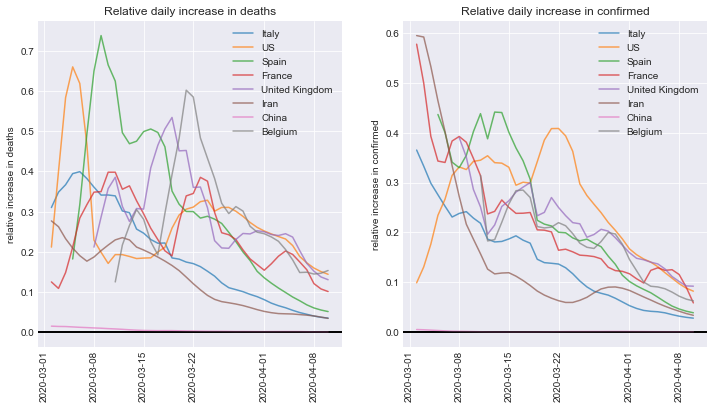

In [197]:
find_relative_increase_data_and_plot(dfp_country, n_locales=8, col_locale='country', dt=datetime.datetime(2020,3,2))

##### Forecasts based on last 2 weeks

confirmed_pred            deaths_pred             \
date               2020-04-11 2020-04-17  2020-04-11 2020-04-17   
country                                                           
US                   607525.0  1161321.0     25068.0    70220.0   
Italy                156510.0   193713.0     20667.0    27494.0   
Spain                179494.0   254548.0     18853.0    29403.0   
France               154536.0   280303.0     17418.0    40493.0   
United Kingdom        88144.0   172084.0     12317.0    34418.0   
Iran                  75888.0   102194.0      4520.0     5767.0   
Belgium               30344.0    48722.0      3740.0     9743.0   
Germany              136735.0   193619.0      3600.0     8425.0   
China                 83020.0    83436.0      3348.0     3368.0   
Netherlands           25592.0    37632.0      3132.0     5834.0   

               mortality_rate_pred            frac_increase_confirmed  \
date                    2020-04-11 2020-04-17                           
country                                                                 
US                        0.041262   0.060466                0.114033   
Italy                     0.132049   0.141932                0.036182   
Spain                     0.105034   0.115511                0.059953   
France                    0.112712   0.144462                0.104332   
United Kingdom            0.139737   0.200007                0.117956   
Iran                      0.059561   0.056432                0.050853   
Belgium                   0.123253   0.199971                0.082118   
Germany                   0.026328   0.043513                0.059688   
China                     0.040328   0.040366                0.000833   
Netherlands               0.122382   0.155028                0.066369   

               frac_increase_deaths  
date                                 
country                              
US                         0.187284  
Italy                      0.048714  
Spain                      0.076880  
France                     0.150969  
United Kingdom             0.186805  
Iran                       0.041423  
Belgium                    0.173018  
Germany                    0.152251  
China                      0.000988  
Netherlands                0.109188

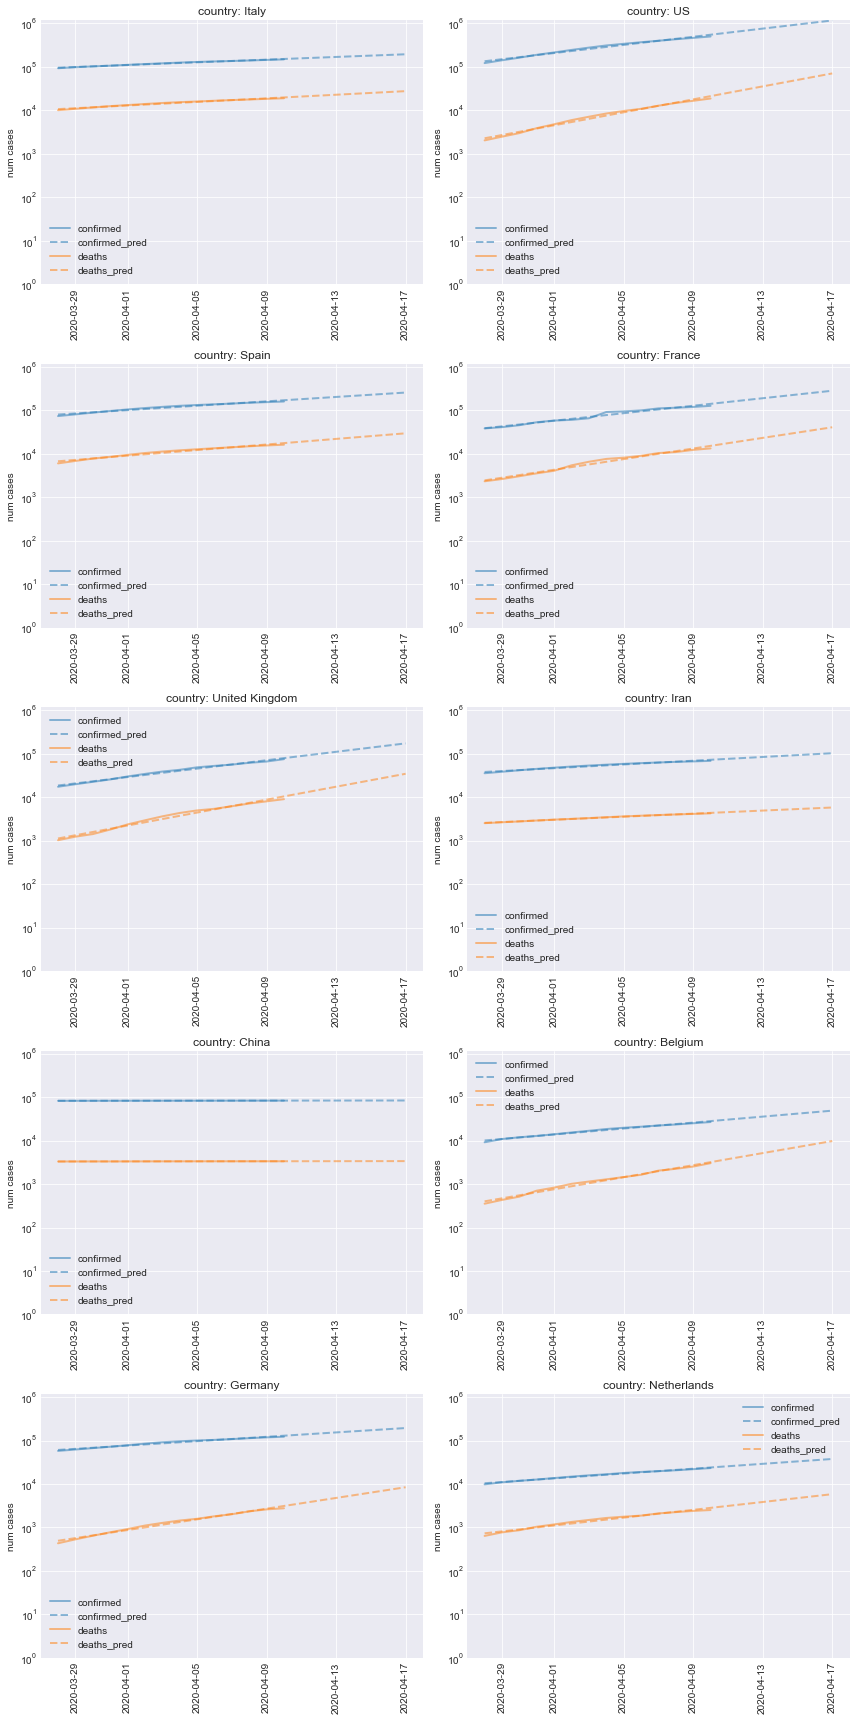

In [198]:
dfp_country_recent_2, dfp_forecasts_out_2 = fit_exp(dfp_country, 
                                                    n_days_predict=14, 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_2)

In [199]:
save_forecast(dfp_forecasts_out_2, dfp_country_recent_2, 14)

saved forecast to predictions/covid-19_country_forecast_from_2020-04-10_n_days_training=14.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [200]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.4f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

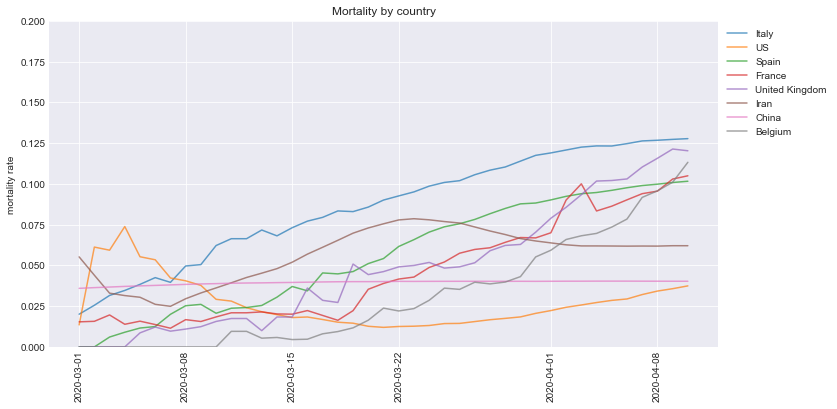

In [201]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [202]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    x_col='confirmed',
    y_col='mortality_rate'
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot[x_col], dfp_plot[y_col], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlabel('# confirmed cases')
    #plt.ylabel('mortality rate')
    plt.xlabel(x_col.replace('_', ' '))
    plt.ylabel(y_col.replace('_', ' '))
    plt.title(f'Mortality vs confirmed cases by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

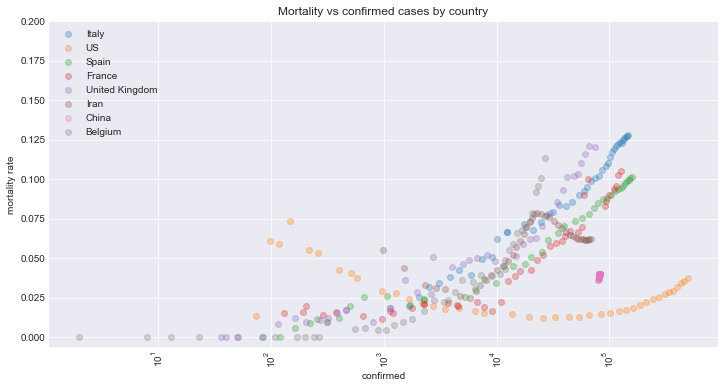

In [203]:
plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [204]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(['country'], as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

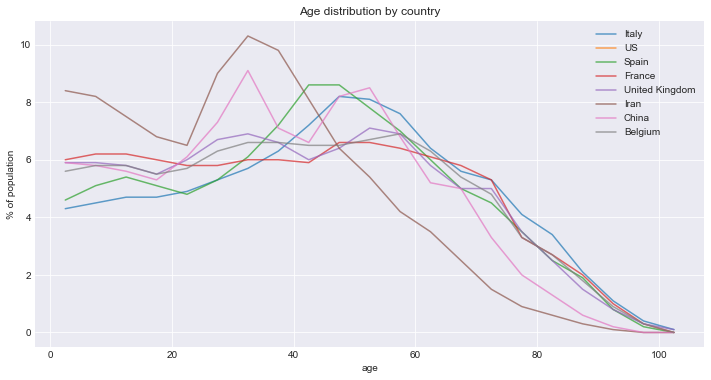

In [205]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']
for country in countries:
    dfp_plot = dfp_demo[dfp_demo.country == country]
    plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
plt.xlabel('age')
plt.ylabel('% of population')
plt.title('Age distribution by country')
plt.legend(loc='best')
plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

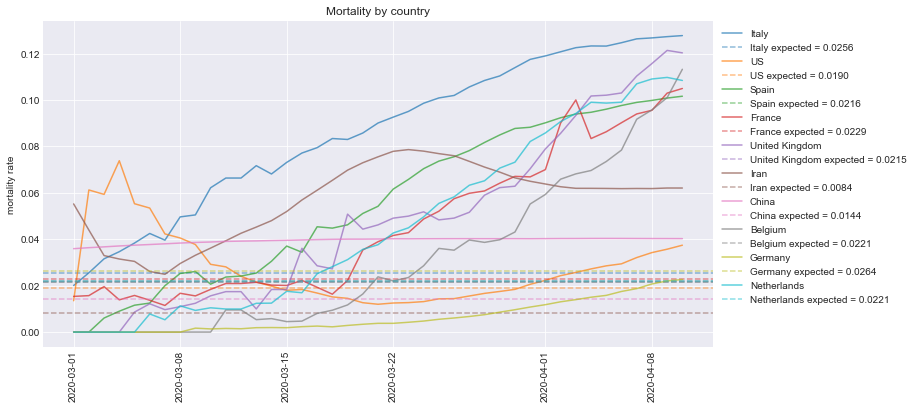

,date,country,mortality_rate,confirmed,deaths
0,2020-04-10,Italy,0.127723,147577.0,18849.0
1,2020-04-10,United Kingdom,0.120287,74605.0,8974.0
2,2020-04-10,Belgium,0.113211,26667.0,3019.0
3,2020-04-10,Netherlands,0.108392,23249.0,2520.0
4,2020-04-10,France,0.104938,125931.0,13215.0
5,2020-04-10,Spain,0.101603,158273.0,16081.0
6,2020-04-10,Iran,0.062060,68192.0,4232.0
7,2020-04-10,China,0.040270,82941.0,3340.0
8,2020-04-10,US,0.037431,496535.0,18586.0
9,2020-04-10,Germany,0.022649,122171.0,2767.0


In [206]:
n_countries = 10
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)
dfp_display = (dfp_country[(dfp_country['date'] == dfp_country['date'].max()) & 
                           (dfp_country['country'].isin(countries))
                          ].
               sort_values(by='mortality_rate', ascending=0).
               reset_index(drop=True)
              )[['date', 'country', 'mortality_rate', 'confirmed', 'deaths']]
display(dfp_display)

**Remarks about the mortality rate being above the expected mortality rate**

Assuming the [cited report](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) of age-wise mortality is correct and that the virus is homogeneously distributed amongst the population, a discrepancy like this could arise if the country has:
- Preferentially tested people in critical condition, ignoring test for mild cases (perhaps if testing capacity is saturated)
- An overloaded hospital system, where patients are not receiving the same quality of care they would otherwise

If the testing is biased, we can estimate the true number of infections by multiplying the confirmed cases by the ratio between the measured mortality rate and the expected mortality rate.  For example, in Iran (as of 2020-03-22), we might estimate the true number of cases is 9.3x higher using this method (200,589 vs 21,638).

### Distribution of expected mortality fractions

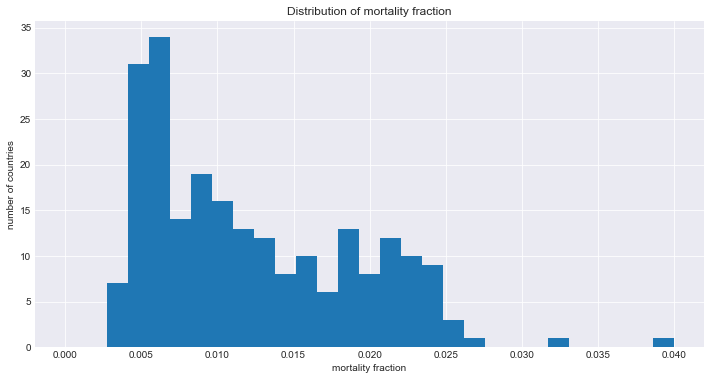

In [207]:
dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
plt.title('Distribution of mortality fraction')
plt.ylabel('number of countries')
plt.xlabel('mortality fraction')
plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [208]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

,country,frac_mortality,num_deaths_max_expected,pop
1,Japan,0.031837,3998380.024,125507472
2,Germany,0.026398,2128411.026,80159662
3,Greece,0.025745,271233.247,10607051
4,Italy,0.025637,1599267.592,62402659
10,Portugal,0.023736,244829.259,10302674
18,France,0.022950,1564984.503,67848156
20,Sweden,0.022575,231555.716,10202491
23,Belgium,0.022146,259573.363,11720716
24,Netherlands,0.022076,382222.125,17280397
27,Canada,0.021712,820035.480,37694085


<a id='density_of_infections_by_country'></a>
# Density of infections per million people

In [209]:
# plot of country fractions that are infected
dfp_country_pop = dfp_country.merge(dfp_country_mortality_expected[['country', 'pop']], on='country', how='left').copy()
dfp_country_pop['deaths_per_million'] = dfp_country_pop['deaths'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_per_million'] = dfp_country_pop['confirmed'] / dfp_country_pop['pop'] * 1E6

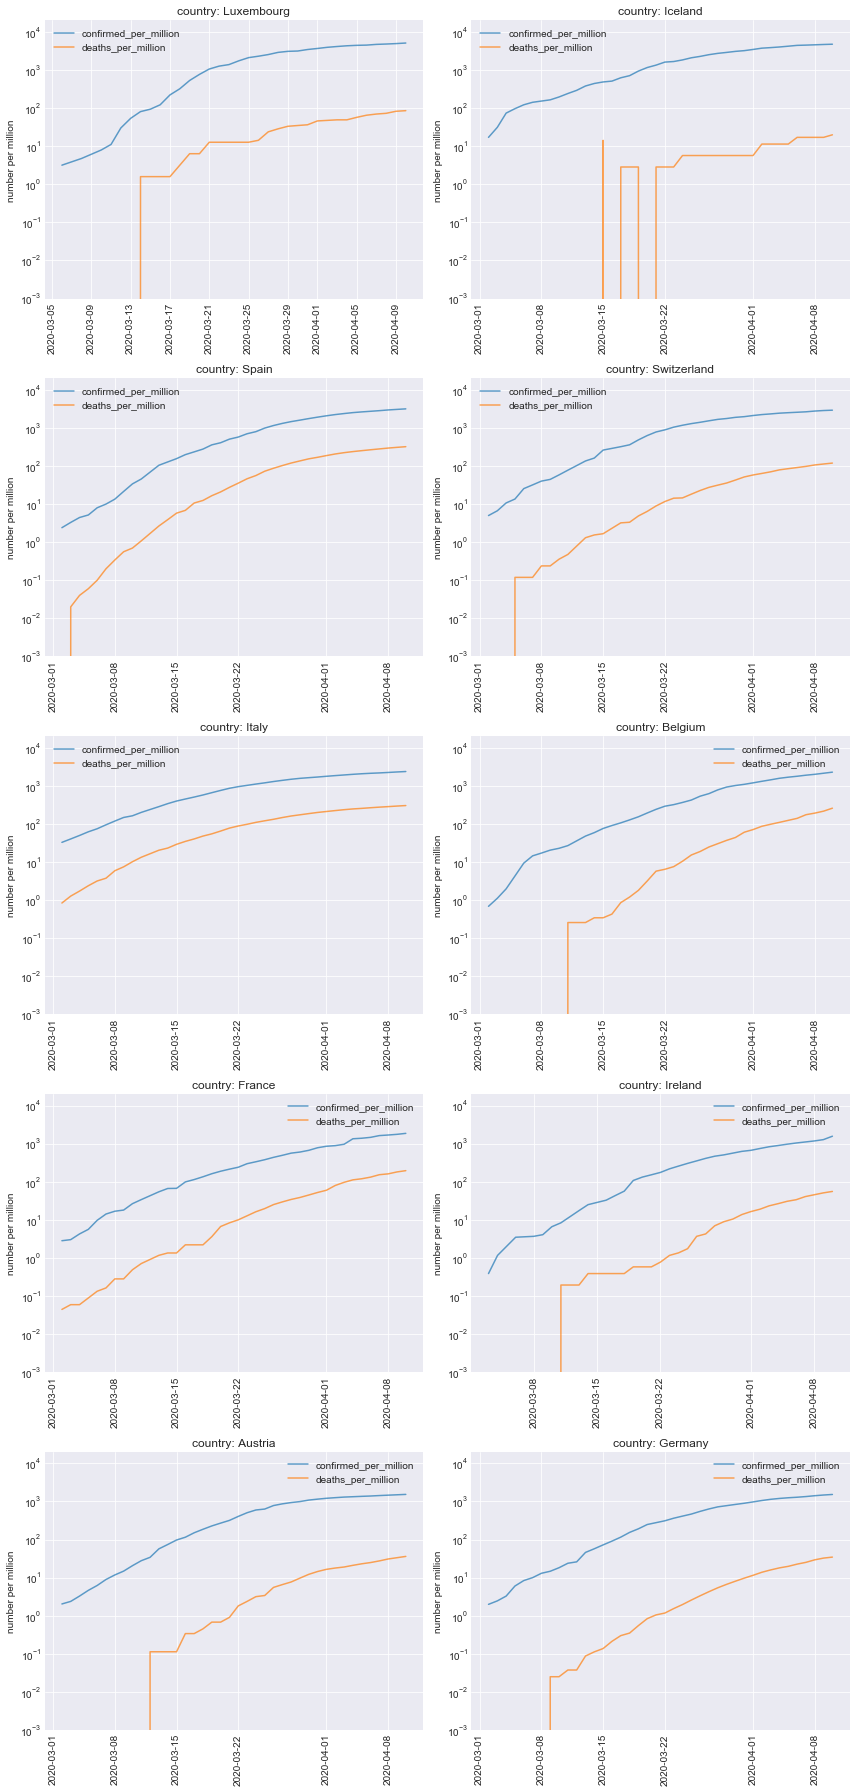

,country,population,confirmed,deaths,confirmed_per_million,deaths_per_million,mortality_rate
0,Luxembourg,628381.0,3223.0,54.0,5129.053870,85.935125,0.016755
1,Iceland,350734.0,1675.0,7.0,4775.698963,19.958145,0.004179
2,Spain,50015792.0,158273.0,16081.0,3164.460537,321.518452,0.101603
3,Switzerland,8403994.0,24551.0,1002.0,2921.349063,119.229024,0.040813
4,Italy,62402659.0,147577.0,18849.0,2364.915251,302.054436,0.127723
5,Belgium,11720716.0,26667.0,3019.0,2275.202300,257.578121,0.113211
6,France,67848156.0,125931.0,13215.0,1856.071077,194.773164,0.104938
7,Ireland,5176569.0,8089.0,287.0,1562.618020,55.442128,0.035480
8,Austria,8859449.0,13555.0,319.0,1530.004857,36.006754,0.023534
9,Germany,80159662.0,122171.0,2767.0,1524.095748,34.518609,0.022649


In [210]:
n_countries = 10
dfp_country_pop_top = (dfp_country_pop[(dfp_country_pop['date'] == dfp_country_pop['date'].max()) &
                                       (dfp_country_pop['pop'] >= 1E5)
                                      ].
                       sort_values(by='confirmed_per_million', ascending=0).
                       reset_index(drop=True)
                      )

plot_countries(dfp_country_pop, 
               countries=dfp_country_pop_top.iloc[:n_countries]['country'],
               plot_cols=['confirmed_per_million', 'deaths_per_million'],
               country_col='country',
               y_max=dfp_country_pop['confirmed_per_million'].max()*2,
               y_min=0.001,
               y_label='number per million',
               date_min=datetime.datetime(2020,3,2)
              )
display_cols = ['country', 'pop', 'confirmed', 'deaths', 'confirmed_per_million', 'deaths_per_million', 'mortality_rate']
display(dfp_country_pop_top[display_cols].rename(columns={'pop': 'population'}).head(10))

### Mortality rate by deaths per capita, confirmed per capita

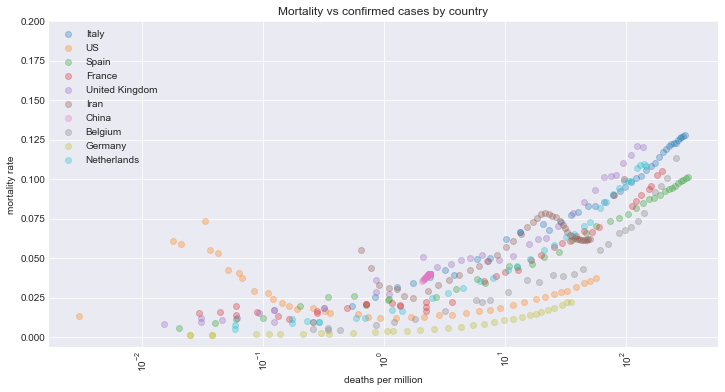

In [211]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='deaths_per_million', 
                                  y_col='mortality_rate'
                                 )

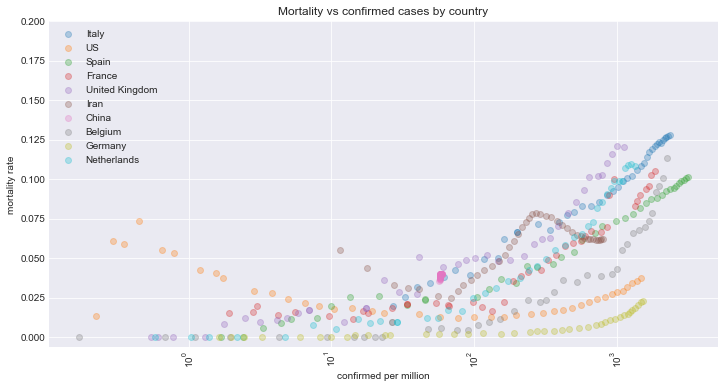

In [212]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='confirmed_per_million', 
                                  y_col='mortality_rate'
                                 )

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [213]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_pop, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

##### Days behind Italy via density of cases

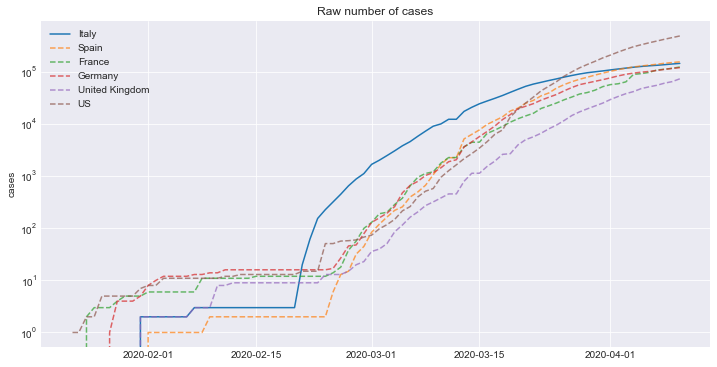

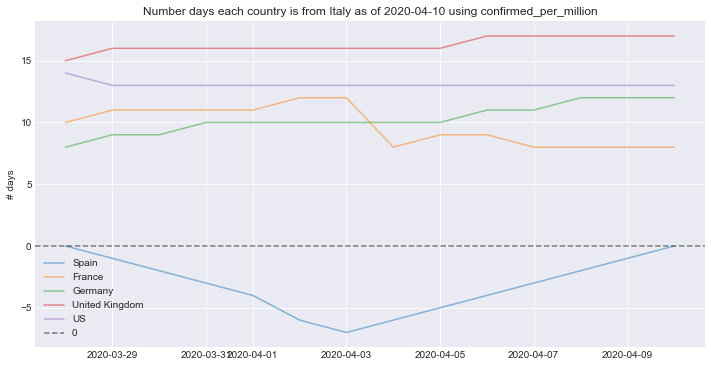

In [214]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed_per_million')

##### Days behind Italy via number of confirmed cases

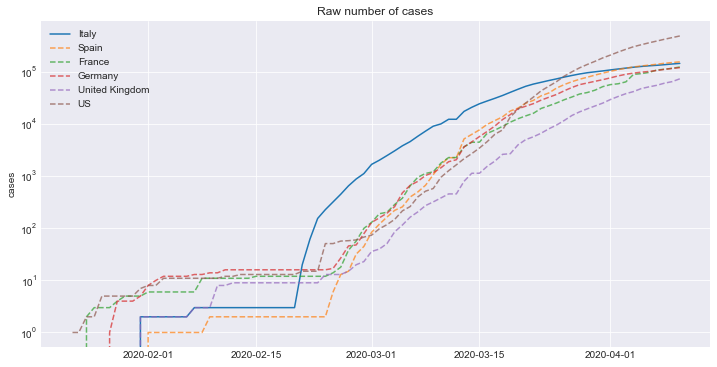

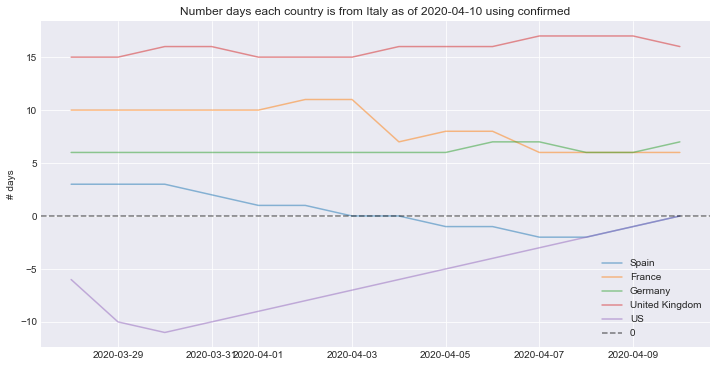

In [215]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed')

# US state breakdown

In [216]:
# load and clean data
dfp_us_raw = pd.read_csv('state_data/states-daily.csv')
dfp_us_raw = dfp_us_raw.rename(columns={'state': 'state_clean_1',
                                        'positive': 'confirmed',
                                        'death': 'deaths',
                                        'date': 'date_str'
                                       })
dfp_us_raw['date'] = dfp_us_raw['date_str'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
dfp_us_raw['country'] = 'US'

In [217]:
# load and clean data from CSSEGIS
state_base_dir = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
data_paths_raw = os.listdir(state_base_dir)
data_paths = [path for path in data_paths_raw if path.endswith('csv')]
list_dfp_states = []
cols_of_interest = ['country', 'state', 'date', 'confirmed', 'deaths', 'recovered']
for path in data_paths:
    full_path = os.path.join(state_base_dir, path)
    
    # read state data
    dfp_temp = pd.read_csv(full_path)
    cols = list(dfp_temp.columns)
    
    # clean column names
    cols_translate = {'Country/Region': 'country',
                      'Province/State': 'state',
                      'Confirmed': 'confirmed',
                      'Deaths': 'deaths',
                      'Recovered': 'recovered',
                      'Country_Region': 'country',
                      'Province_State': 'state',
                      'Last_Update': 'Last Update'
                     }
    dfp_temp = dfp_temp.rename(columns=cols_translate)
    dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())
    dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
    dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
    list_dfp_states.append(dfp_temp[cols_of_interest])
dfp_us_raw = pd.concat(list_dfp_states)
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

In [218]:
# look only at the US
#dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
#dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

In [219]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                #'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
#dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [220]:
id_cols_state = ['date', 'state']
value_cols_state = ['confirmed', 'confirmed_new', 'deaths', 'deaths_new', 'mortality_rate']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols_state]
dfp_us_top_states = dfp_us_top_states.sort_values(by='deaths', ascending=0).reset_index(drop=True)
dfp_us_top_states = dfp_us_top_states.fillna(0)
for key in value_cols_state:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(10)

,date,state,confirmed,confirmed_new,deaths,deaths_new,mortality_rate
0,2020-04-10,New York,172348,10569,7867,800,0.045646
1,2020-04-10,New Jersey,54588,3561,1932,223,0.035392
2,2020-04-10,Michigan,22434,930,1276,200,0.056878
3,2020-04-10,Louisiana,19253,970,755,53,0.039215
4,2020-04-10,Massachusetts,20974,2033,599,96,0.028559
5,2020-04-10,Illinois,17887,2808,597,135,0.033376
6,2020-04-10,California,21081,1371,583,39,0.027655
7,2020-04-10,Washington,10119,480,483,27,0.047732
8,2020-04-10,Connecticut,10538,754,448,68,0.042513
9,2020-04-10,Pennsylvania,20051,1751,418,73,0.020847


<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [221]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

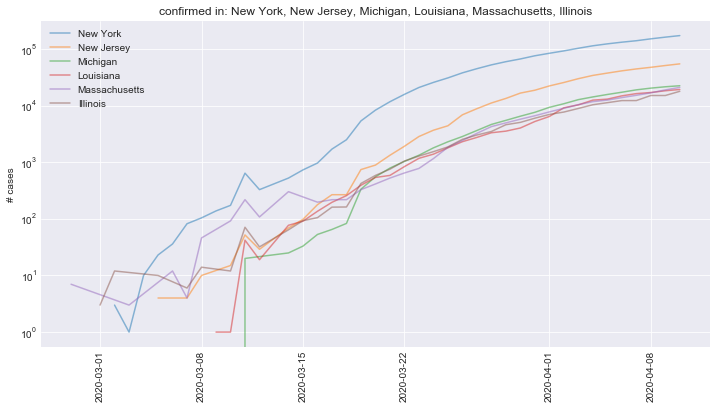

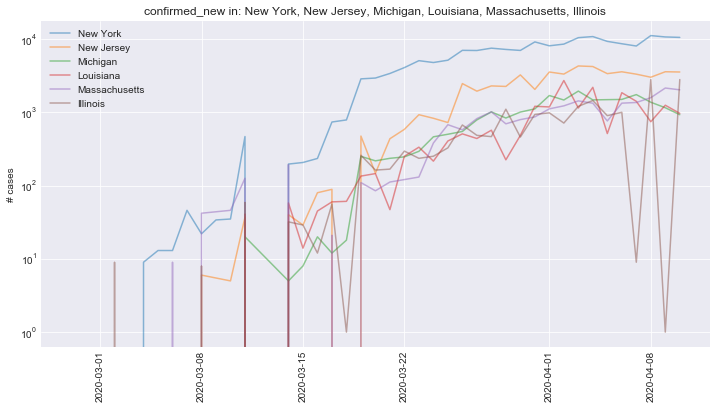

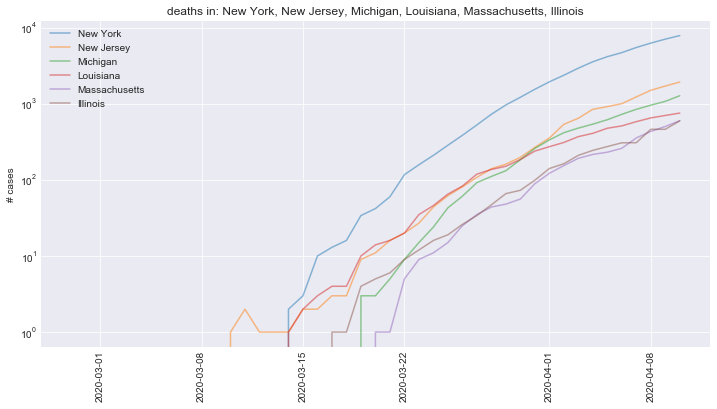

In [222]:
states_oi = dfp_us_top_states.iloc[:6]['state'].values
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed')
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new')
plot_state_data(dfp_us_g, states_oi, plot_col='deaths')

<a id='forecast_us_state'></a>
### Forecast by state

confirmed_pred                       deaths_pred             \
date              2020-04-11 2020-04-17 2020-05-01  2020-04-11 2020-04-17   
state                                                                       
New York            185196.0   279823.0   733056.0      9185.0    20397.0   
New Jersey           59690.0    95005.0   280998.0      2253.0     5457.0   
Michigan             25066.0    39824.0   117290.0      1461.0     3421.0   
Louisiana            21242.0    33409.0    96100.0       860.0     1585.0   
Massachusetts        22870.0    41375.0   164999.0       721.0     2163.0   
California           23347.0    37369.0   111982.0       680.0     1369.0   
Illinois             18736.0    31539.0   106311.0       652.0     1584.0   
Connecticut          11932.0    24119.0   124593.0       535.0     1515.0   
Pennsylvania         22816.0    44402.0   209936.0       526.0     1746.0   
Washington           10795.0    14978.0    32161.0       526.0      809.0   

                         mortality_rate_pred                        \
date          2020-05-01          2020-04-11 2020-04-17 2020-05-01   
state                                                                
New York        131236.0            0.049596   0.072893   0.179026   
New Jersey       42985.0            0.037745   0.057439   0.152973   
Michigan         24895.0            0.058286   0.085903   0.212252   
Louisiana         6604.0            0.040486   0.047442   0.068720   
Massachusetts    28073.0            0.031526   0.052278   0.170140   
California        7002.0            0.029126   0.036635   0.062528   
Illinois         12541.0            0.034799   0.050224   0.117965   
Connecticut      17144.0            0.044837   0.062814   0.137600   
Pennsylvania     28656.0            0.023054   0.039323   0.136499   
Washington        2204.0            0.048726   0.054013   0.068530   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.071212             0.142217  
New Jersey                   0.080537             0.158835  
Michigan                     0.080210             0.152288  
Louisiana                    0.078389             0.107287  
Massachusetts                0.103850             0.200915  
California                   0.081546             0.123604  
Illinois                     0.090672             0.159258  
Connecticut                  0.124445             0.189223  
Pennsylvania                 0.117357             0.221214  
Washington                   0.056100             0.074223

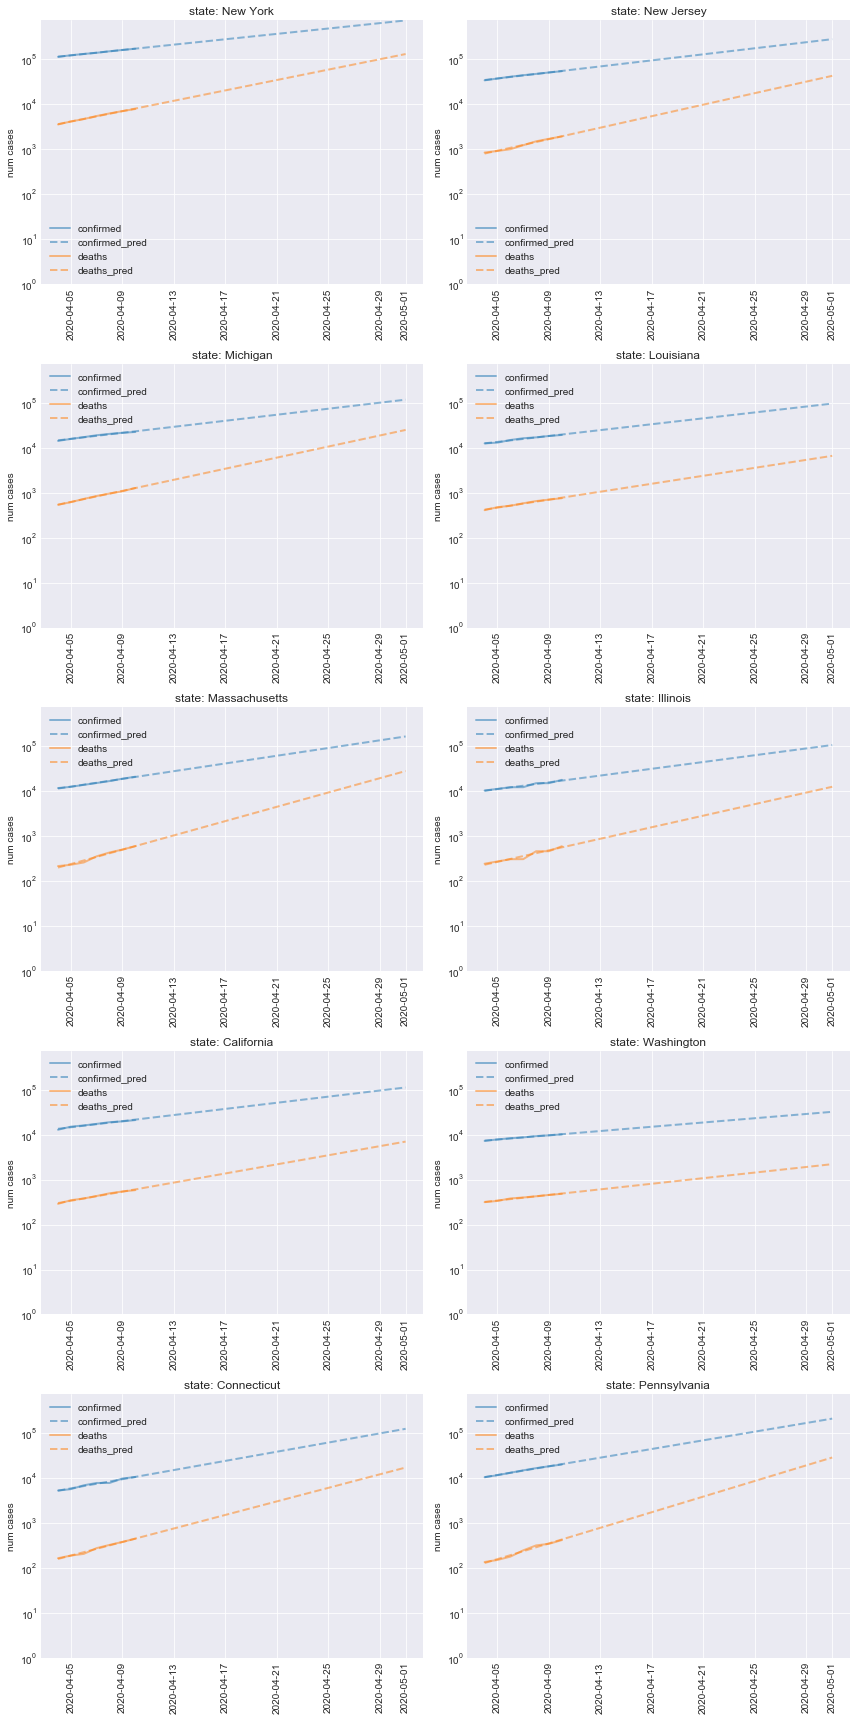

In [223]:
dfp_state_recent_1, dfp_state_forecasts_out_1 = fit_exp(dfp_us_g, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_1, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

confirmed_pred                       deaths_pred             \
date              2020-04-11 2020-04-17 2020-05-01  2020-04-11 2020-04-17   
state                                                                       
New York            202140.0   348541.0  1242575.0     11165.0    33243.0   
New Jersey           71047.0   147181.0   805206.0      2902.0    10309.0   
Michigan             30210.0    63600.0   361274.0      1758.0     5262.0   
Louisiana            28150.0    68375.0   542253.0       982.0     2202.0   
Massachusetts        25058.0    51730.0   280701.0       805.0     2745.0   
Illinois             21165.0    42725.0   220051.0       771.0     2352.0   
California           26466.0    50872.0   233692.0       724.0     1594.0   
Connecticut          13212.0    30546.0   215916.0       629.0     2238.0   
Washington           11507.0    17562.0    47094.0       536.0      853.0   
Pennsylvania         26812.0    67005.0   567885.0       515.0     1654.0   

                         mortality_rate_pred                        \
date          2020-05-01          2020-04-11 2020-04-17 2020-05-01   
state                                                                
New York        423936.0            0.055234   0.095378   0.341175   
New Jersey      198502.0            0.040846   0.070043   0.246523   
Michigan         67932.0            0.058193   0.082736   0.188035   
Louisiana        14473.0            0.034885   0.032205   0.026690   
Massachusetts    48031.0            0.032125   0.053064   0.171111   
Illinois         31769.0            0.036428   0.055050   0.144371   
California       10041.0            0.027356   0.031334   0.042967   
Connecticut      43252.0            0.047608   0.073267   0.200319   
Washington        2520.0            0.046580   0.048571   0.053510   
Pennsylvania     25214.0            0.019208   0.024685   0.044400   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.095049             0.199421  
New Jersey                   0.129063             0.235242  
Michigan                     0.132098             0.200461  
Louisiana                    0.159407             0.143959  
Massachusetts                0.128403             0.226830  
Illinois                     0.124204             0.204336  
California                   0.115057             0.140459  
Connecticut                  0.149915             0.235567  
Washington                   0.072998             0.080469  
Pennsylvania                 0.164921             0.214761

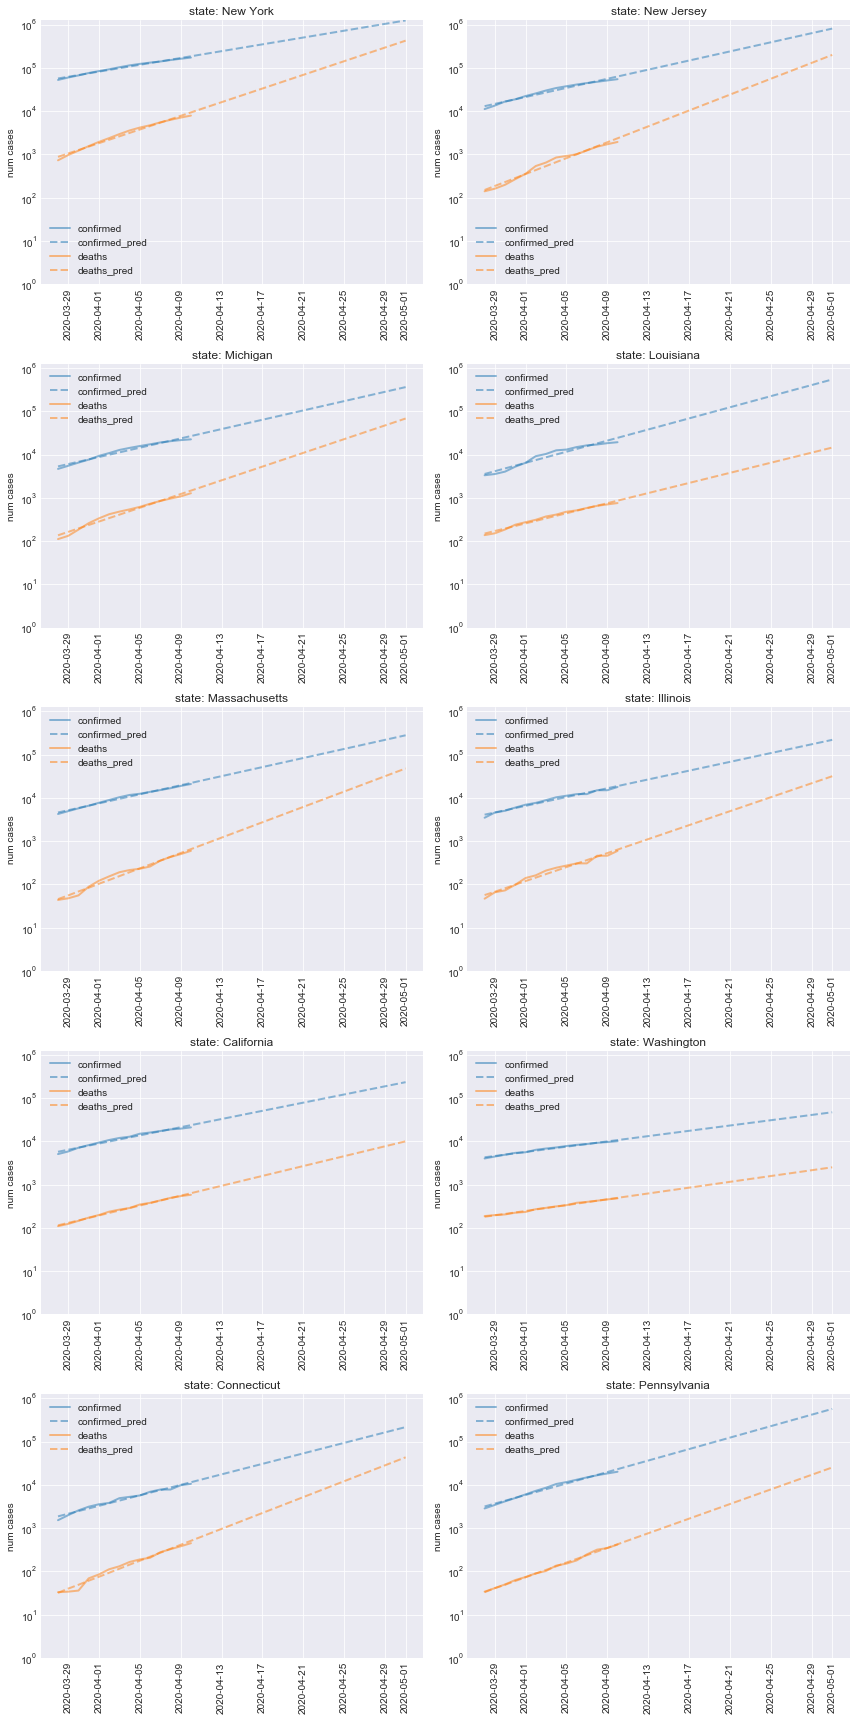

In [224]:
dfp_state_recent_2, dfp_state_forecasts_out_2 = fit_exp(dfp_us_g, 
                                                    n_days_predict=14,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_2, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

<a id='us_state_daily_increase_fraction'></a>
##### States and their daily increase fraction in confirmed cases/deaths
Computed via linear fit of the log of the confirmed cases/deaths over the last 7 days.

In [225]:
# increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
# curr_cols = ['date', 'state', 'confirmed', 'deaths']
# dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
# for col in ['confirmed', 'deaths']:
#     dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)

In [226]:
# latest date
dt_latest = dfp_us_g['date'].max()
dfp_us_g_latest = dfp_us_g[dfp_us_g['date'] == dt_latest].copy()

# what is the distribution in % increase in deaths?
dfp_state_increase = (dfp_state_forecasts_out_1[(dfp_state_forecasts_out_1['date'] == dfp_state_forecasts_out_1['date'].max()) &
                                                (dfp_state_forecasts_out_1['deaths_pred'] > 2)
                                               ].
                      sort_values(by='frac_increase_deaths', ascending=0).
                      reset_index(drop=True)
                     )
increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
curr_cols = ['date', 'state', 'confirmed', 'deaths']
dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
for col in ['confirmed', 'deaths']:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)
(dfp_state_increase_m[['date', 'state', 'confirmed', 'deaths', 'frac_increase_confirmed', 'frac_increase_deaths']].
 sort_values(by='frac_increase_deaths', ascending=0).
 reset_index(drop=True)
)


,date,state,confirmed,deaths,frac_increase_confirmed,frac_increase_deaths
0,2020-04-10,South Dakota,536,6,1.675467e-01,2.344946e-01
1,2020-04-10,Pennsylvania,20051,418,1.173566e-01,2.212141e-01
2,2020-04-10,Missouri,3897,99,9.293823e-02,2.125734e-01
3,2020-04-10,New Hampshire,819,21,6.818221e-02,2.108986e-01
4,2020-04-10,Maryland,6968,171,1.449935e-01,2.046194e-01
5,2020-04-10,Massachusetts,20974,599,1.038497e-01,2.009152e-01
6,2020-04-10,Connecticut,10538,448,1.244450e-01,1.892234e-01
7,2020-04-10,Indiana,6907,300,9.671018e-02,1.749821e-01
8,2020-04-10,North Carolina,3965,83,8.385872e-02,1.721172e-01
9,2020-04-10,Idaho,1354,24,4.398895e-02,1.621432e-01


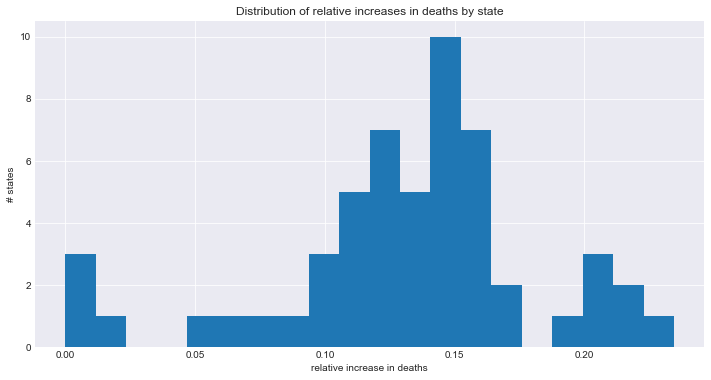

In [227]:
dfp_state_increase_m['frac_increase_deaths'].hist(bins=20)
plt.xlabel('relative increase in deaths')
plt.ylabel('# states')
plt.title('Distribution of relative increases in deaths by state')
plt.show()

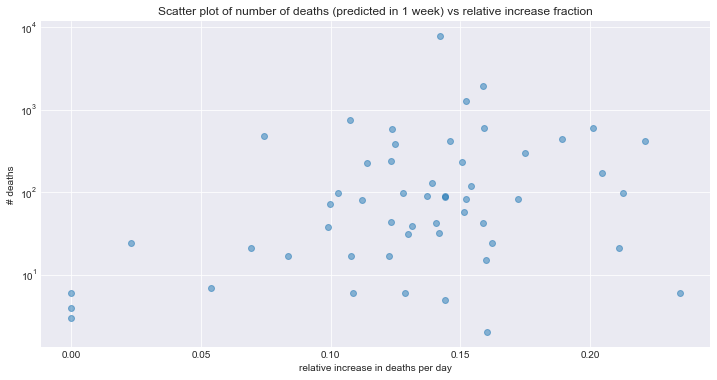

In [228]:
plt.plot(dfp_state_increase_m['frac_increase_deaths'], dfp_state_increase_m['deaths'], 'o', alpha=0.5)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('relative increase in deaths per day')
plt.ylabel('# deaths')
plt.title('Scatter plot of number of deaths (predicted in 1 week) vs relative increase fraction')
plt.show()

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

In [229]:
dfp_us_g = dfp_us_g[~(dfp_us_g['date']==datetime.datetime(2020,3,9))]

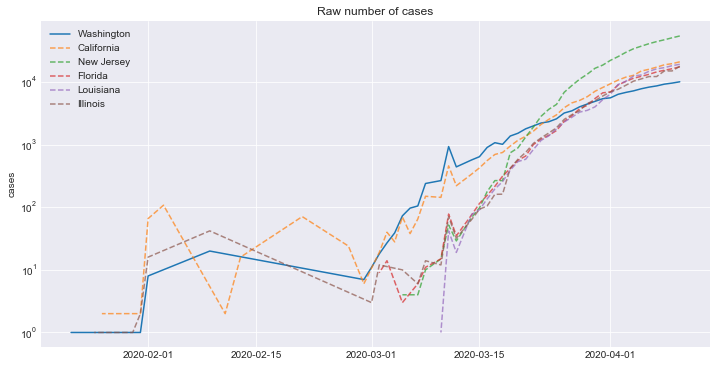

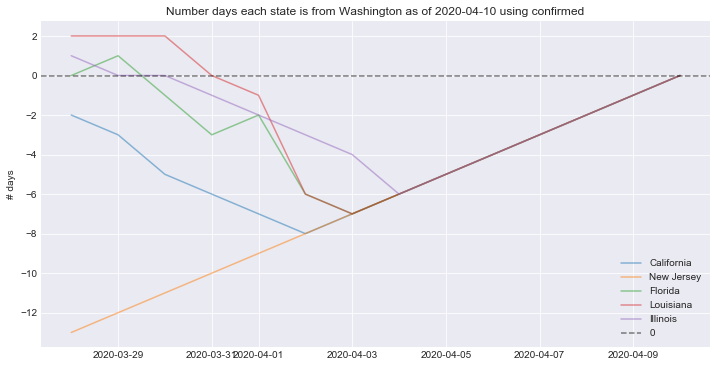

In [230]:
_ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'Washington', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

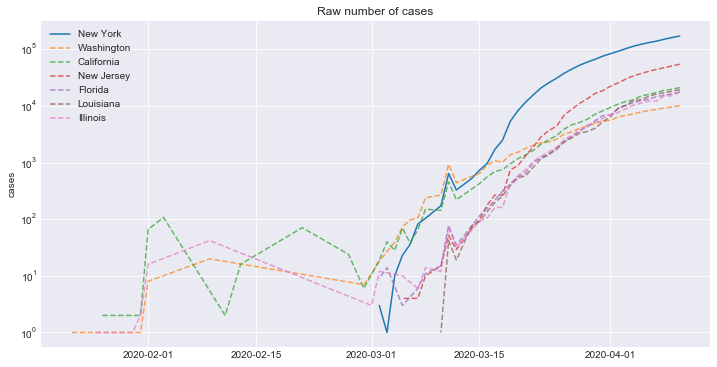

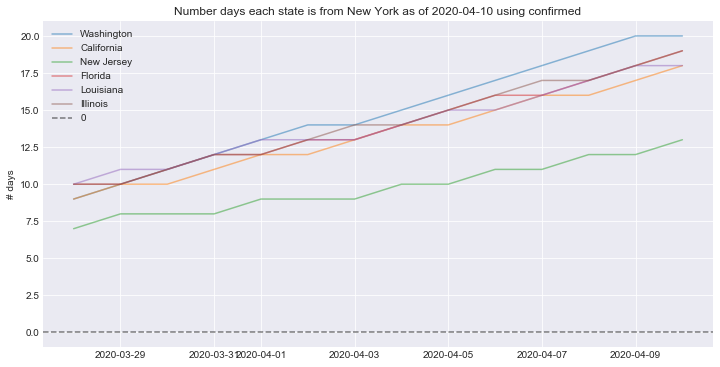

In [231]:
_ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'New York', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

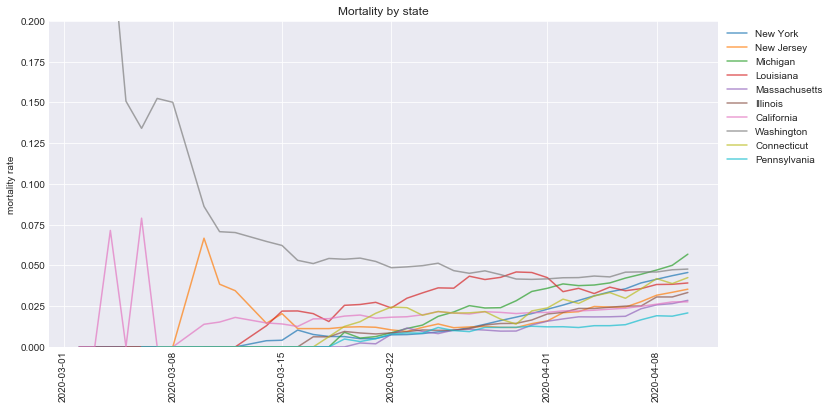

In [232]:
n_states = 10
states = dfp_us_top_states.iloc[:n_states]['state']

plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,2))

##### Relationship between mortality rate and number of cases

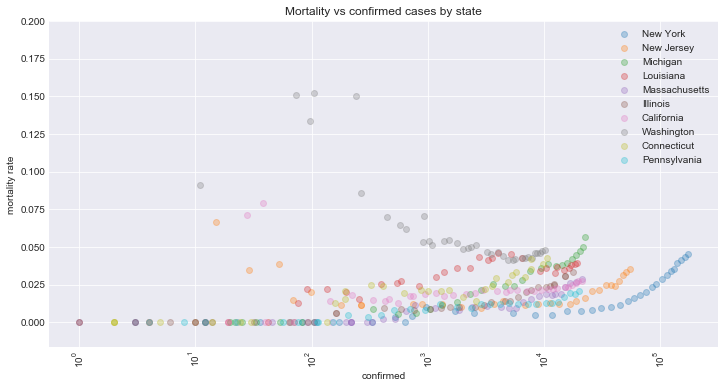

In [233]:
plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

<a id='us_state_relative_increases'></a>
### Relative increases per day by state

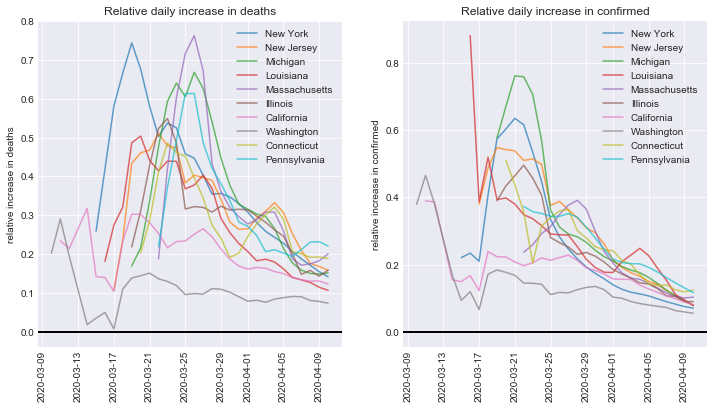

In [234]:
find_relative_increase_data_and_plot(dfp_us_g, n_locales=10, col_locale='state')
